### Run in Google Colab

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/132iofF7rVTKySPHHPZ6tkgkvCb6bYf9V?usp=sharing)

### Setup your API key

Before you can use the OpenAI API, you must first obtain an API key. If you don't already have one, create a key for OPENAI_API_KEY which is obtained from: https://openai.com/blog/openai-api

In Colab, add the key to the secrets manager under the "🔑" in the left panel. Give it the name `OPENAI_API_KEY`.


### Mount this Colab notebook at Google Drive
To ensure your work is saved and can be accessed later, it's a good practice to mount your Google Drive to this Colab notebook. You can do this by running the following code. This will prompt you to authorize Colab to access your Google Drive account. After authorization, your Google Drive will be mounted, and you can save your files directly to it.

In [ ]:
# Used to securely store your API key
from google.colab import userdata
api_key = userdata.get('OPENAI_API_KEY')

# Mount google drive in the virtual envrionment
from google.colab import drive
drive.mount('/content/drive')

### Download necessary data for modeling

In [ ]:
import os
output_folder = "/content/drive/MyDrive/data_driven_building_energy_modeling/"
if not os.path.exists(output_folder):
  os.mkdir(output_folder)

# small office reference building
!gdown --id 1yzsCoKdFAvRGVPPD-SPoUTcco8SkVmp- -O /content/drive/MyDrive/data_driven_building_energy_modeling/input.csv
!gdown --id 1-1jHrklo99cT8UKiZ-eJfdyReUSM23we -O /content/drive/MyDrive/data_driven_building_energy_modeling/output.csv

# NREL campus building
!gdown --id 1_WLzFf6YsOUlAFjaITPkFsYRkTQDQRrb -O /content/drive/MyDrive/data_driven_building_energy_modeling/input_NREL.csv
!gdown --id 1JxDdv3_5Mz2KoUn2fYpEe4ycu7rAZrlB -O /content/drive/MyDrive/data_driven_building_energy_modeling/output_NREL.csv

### Agent Copy Pasted from the run.ipbyn

In [ ]:
!pip install langgraph==0.2.4
!pip install langchain-community==0.2.12
!pip install langchain-openai==0.1.22
!pip install langchain-experimental==0.0.64

In [ ]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

In [ ]:
def run_agent(user_input):
  repl = PythonREPL()
  @tool
  def python_repl(
      code: Annotated[str, "The python code to execute to generate your chart."],
  ):
      """Use this to execute python code. If you want to see the output of a \
      value, you should print it out with `print(...)`. This is visible to the \
      user."""
      try:
          result = repl.run(code)
      except BaseException as e:
          return f"Failed to execute. Error: {repr(e)}"
      result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: \
      {result}"
      return (
          result_str + "\n\nIf you have completed all tasks, respond with FINAL \
          ANSWER."
      )


  class AgentState(TypedDict):
      messages: Annotated[list[AnyMessage], operator.add]

  class Agent:

      def __init__(self, model, tools, system=""):
          self.system = system
          graph = StateGraph(AgentState)
          graph.add_node("agent_node_1", self.call_openai)
          graph.add_node("action_node_1", self.take_action)
          graph.add_conditional_edges(
              "agent_node_1",
              self.exists_action,
              {True: "action_node_1", False: END}
          )
          graph.add_edge("action_node_1", "agent_node_1")
          graph.set_entry_point("agent_node_1")
          self.graph = graph.compile()
          self.tools = {t.name: t for t in tools}
          self.model = model.bind_tools(tools)

      def exists_action(self, state: AgentState):
          result = state['messages'][-1]
          return len(result.tool_calls) > 0

      def call_openai(self, state: AgentState):
          messages = state['messages']
          if self.system:
              messages = [SystemMessage(content=self.system)] + messages
          message = self.model.invoke(messages)
          return {'messages': [message]}

      def take_action(self, state: AgentState):
          tool_calls = state['messages'][-1].tool_calls
          results = []
          for t in tool_calls:
              print(f"Calling: {t}")
              if not t['name'] in self.tools:  # check for bad tool name from LLM
                  print("\n ....bad tool name....")
                  result = "bad tool name, retry"  # instruct LLM to retry if bad
              else:
                  result = self.tools[t['name']].invoke(t['args'])
              results.append(ToolMessage(tool_call_id=t['id'], name=t['name'],
                                        content=str(result)))
          # print("Back to the model!")
          return {'messages': results}

  prompt = """

  You run in a loop of Thought, Action, Observation.

  At the end of the loop you output an answer.

  Imagine you are a machine learning engineer who has to \
  generate and excecute Python code for machine learning modeling with the \
  following 7 steps.
  Step 1 Data Preparation: Prepare data based on the provided two CSV file names \
  with path for input and output data. Clean the data and remove missing values.
  Step 2 Feature Selection: Select important features based on correlation \
  analysis, recursive feature elimination, principal component analysis, \
  wrapper method, or filter method. This step is optional.
  Step 3 Data Splitting: Divide the dataset into three distinct subsets: the \
  training set, validation set, and test set.
  Step 4 Model Selection: Choose suitable machine learning algorithm such as \
  linear regression, decision tree, and random forest based on the validation \
  results.
  Step 5 Hyper Parameter Tuning: Use optimizing model hyperparameters such as \
  grid search or random search to finalize the model.
  Step 6 Model Evaluation: Test the model based on testing data based on any \
  relative error metrics. Visualize the model performance using scatter plots and\
  save it locally.
  Step 7 Save the model locally

  Use the following format:

  Question or Request: create a machine learning model based on local csv files as inputs and output of the machine learning model

  Thought: you should always think about what to do, but bascially you will follow the 7 steps above

  Action Input: the generated Python code to be excecuted

  Action: excecute the Python code based on "python_repl", the Python code excecution tool

  Observation: the result of the action, whether the code is successfully excecuted without error or not

  ... (this Thought/Action/Action Input/Observation can repeat N times)

  Thought: The code is successfully excecuted without error and the machine learning model is successfully saved locally

  Final Answer: the final models are saved at which location

  Example sessions:
  Question: I want to build a machine learning model. The input of the model is from a local csv file: '/content/drive/MyDrive/LLM_data_driven_modeling/input_fx.csv', and the output is also from a local csv file: '/content/drive/MyDrive/LLM_data_driven_modeling/output_fx.csv'
  Thought: I should follow the 7 steps including Data Preparation, Feature Selection, Data Splitting, Model Selection, Hyper Parameter Tuning, Model Evaluation, and Save the model locally.
  Action: generate Python code and use "python_repl" tool to excecute the code
  Observation: There is error in the code excecution. Should debug and improve the code
  Action: improve Python code and use "python_repl" tool to excecute the code
  Observation: There is no error in the code excecution, and the machine learning model is successfully saved locally
  Answer: The machine learning model is successfully developed and saved locally.
  """


  model = ChatOpenAI(temperature=0, model="gpt-4o", openai_api_key = api_key)
  abot = Agent(model, [python_repl], system=prompt)
  messages = [HumanMessage(content=user_input)]
  result = abot.graph.invoke({"messages": messages})
  # print(result)
  # return result

### Evaluation Summary:

Use two different ways to request modeling repeating 10 times based on two different datasets: commercial reference building data and NREL data

The completion rate to model based on Commercial Reference Building data is 70% (7 final figures are generated out of 10 runs), and the completion rate to model based on NREL real building data is 50% (5 final figures are generated out of 10 runs). See details below

#### Commercial Reference Building Data

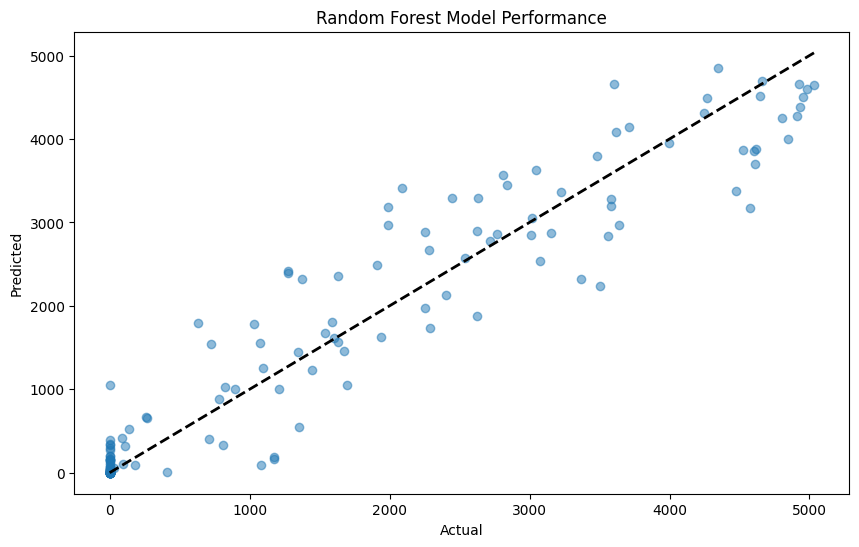

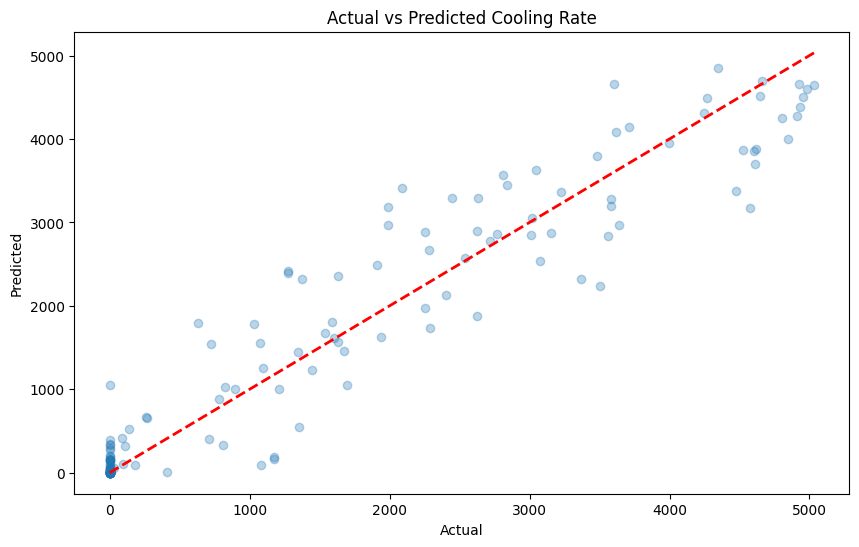

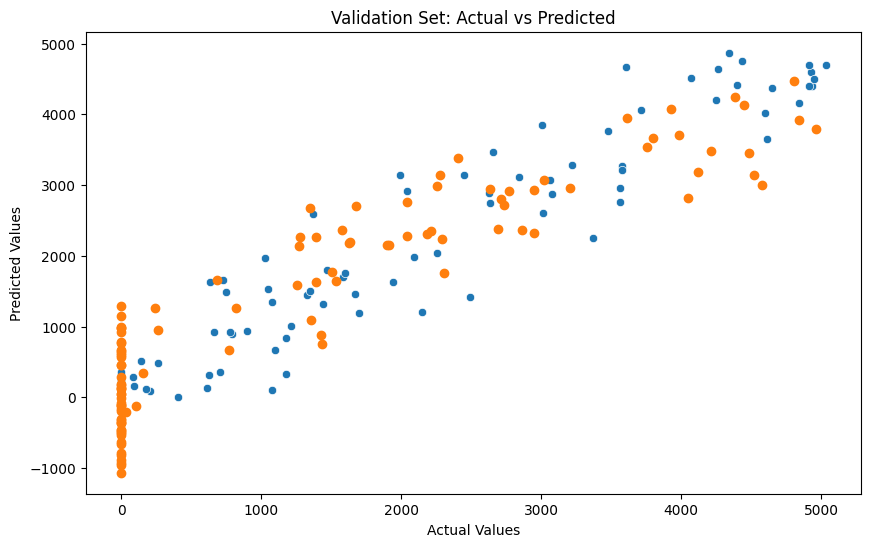

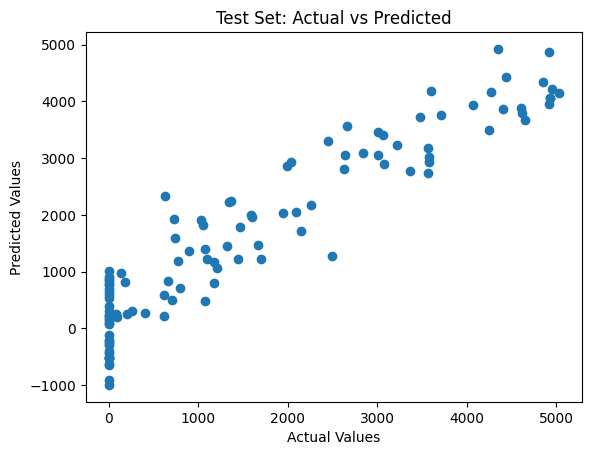

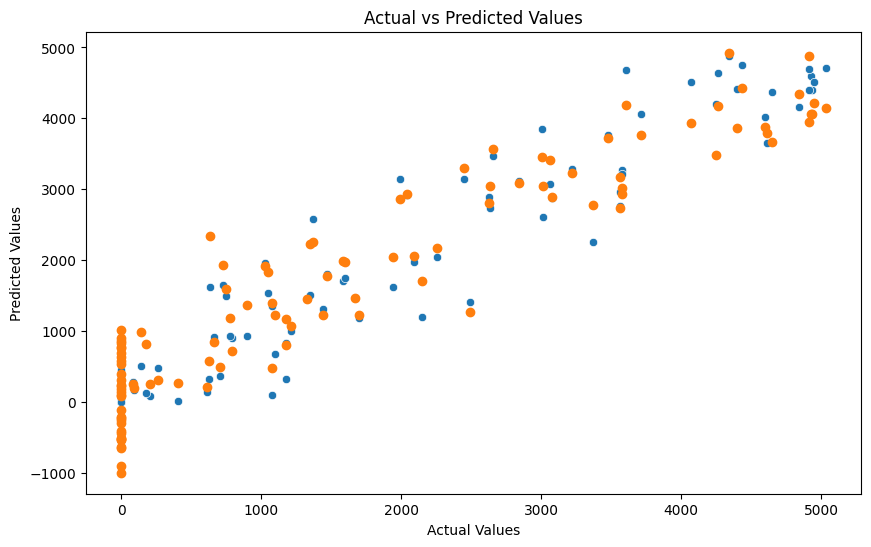

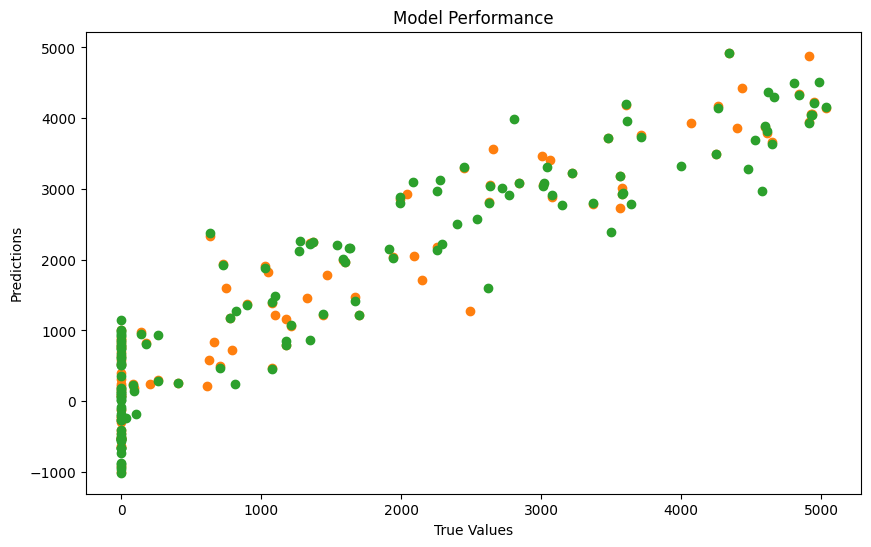

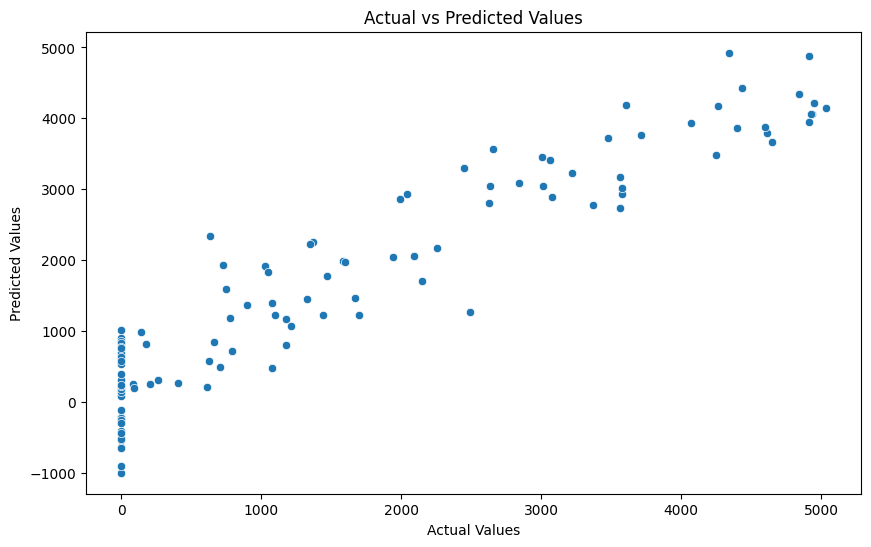

In [ ]:
user_input_list_commercial = ["""Generate a machine learning model to predict next hour's output (energy). The input data of the model is "/content/drive/MyDrive/data_driven_building_energy_modeling/input.csv" and the output data is "/content/drive/MyDrive/data_driven_building_energy_modeling/output.csv" """,
                   """Generate a machine learning model to predict next hour's output (energy). The input data of the model is "/content/drive/MyDrive/data_driven_building_energy_modeling/input.csv" and the output data is "/content/drive/MyDrive/data_driven_building_energy_modeling/output.csv" """,
                   """Generate a machine learning model to predict next hour's output (energy). The input data of the model is "/content/drive/MyDrive/data_driven_building_energy_modeling/input.csv" and the output data is "/content/drive/MyDrive/data_driven_building_energy_modeling/output.csv" """,
                   """Generate a machine learning model to predict next hour's output (energy). The input data of the model is "/content/drive/MyDrive/data_driven_building_energy_modeling/input.csv" and the output data is "/content/drive/MyDrive/data_driven_building_energy_modeling/output.csv" """,
                   """Generate a machine learning model to predict next hour's output (energy). The input data of the model is "/content/drive/MyDrive/data_driven_building_energy_modeling/input.csv" and the output data is "/content/drive/MyDrive/data_driven_building_energy_modeling/output.csv" """,
                   """Input = "The input data of the model is "/content/drive/MyDrive/data_driven_building_energy_modeling/input.csv" and the output data is "/content/drive/MyDrive/data_driven_building_energy_modeling/output.csv",  I want to build a machine learning model based on them.""",
                   """Input = "The input data of the model is "/content/drive/MyDrive/data_driven_building_energy_modeling/input.csv" and the output data is "/content/drive/MyDrive/data_driven_building_energy_modeling/output.csv",  I want to build a machine learning model based on them.""",
                   """Input = "The input data of the model is "/content/drive/MyDrive/data_driven_building_energy_modeling/input.csv" and the output data is "/content/drive/MyDrive/data_driven_building_energy_modeling/output.csv",  I want to build a machine learning model based on them.""",
                   """Input = "The input data of the model is "/content/drive/MyDrive/data_driven_building_energy_modeling/input.csv" and the output data is "/content/drive/MyDrive/data_driven_building_energy_modeling/output.csv",  I want to build a machine learning model based on them.""",
                   """Input = "The input data of the model is "/content/drive/MyDrive/data_driven_building_energy_modeling/input.csv" and the output data is "/content/drive/MyDrive/data_driven_building_energy_modeling/output.csv",  I want to build a machine learning model based on them.""",
                   ]

for user_input in user_input_list_commercial:
  print(f"##################### Processing: {user_input} #########################")
  run_agent(user_input)

NREL Data

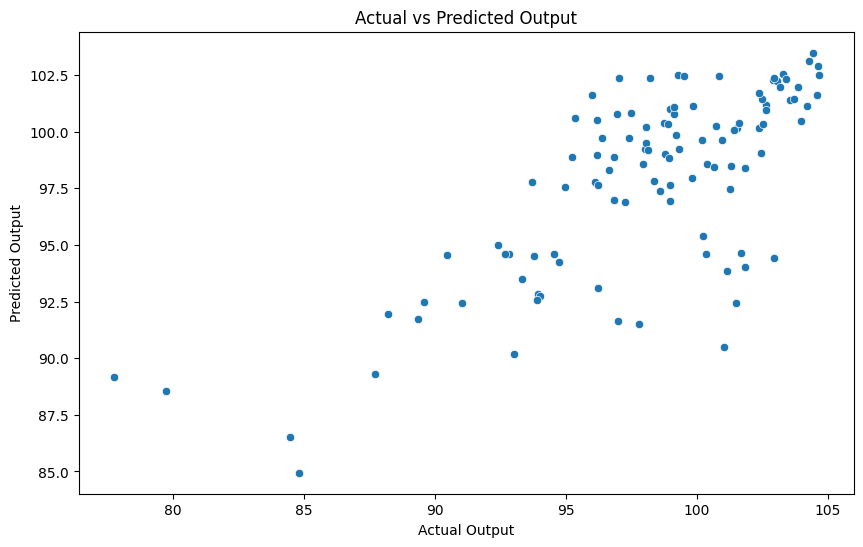

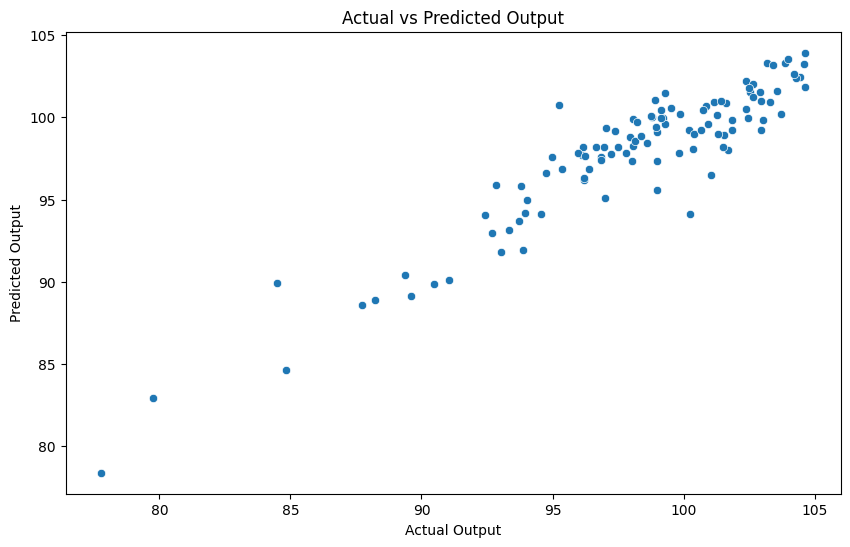

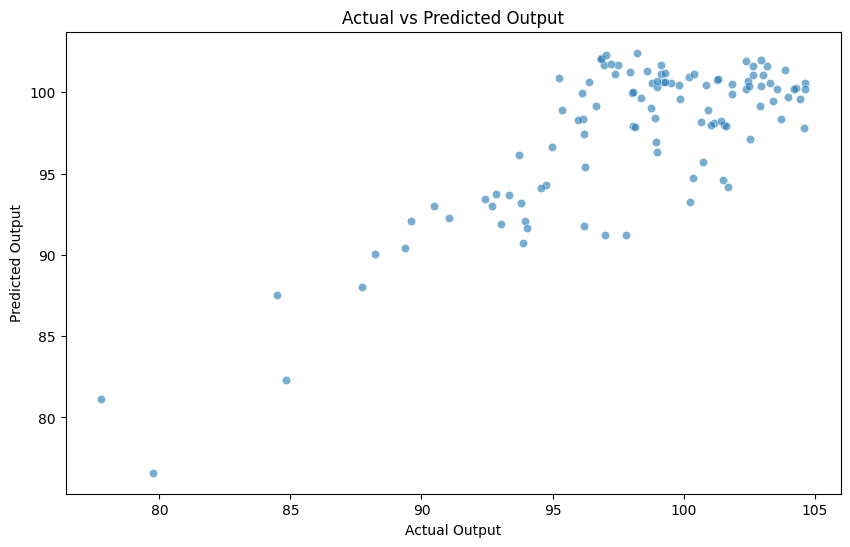

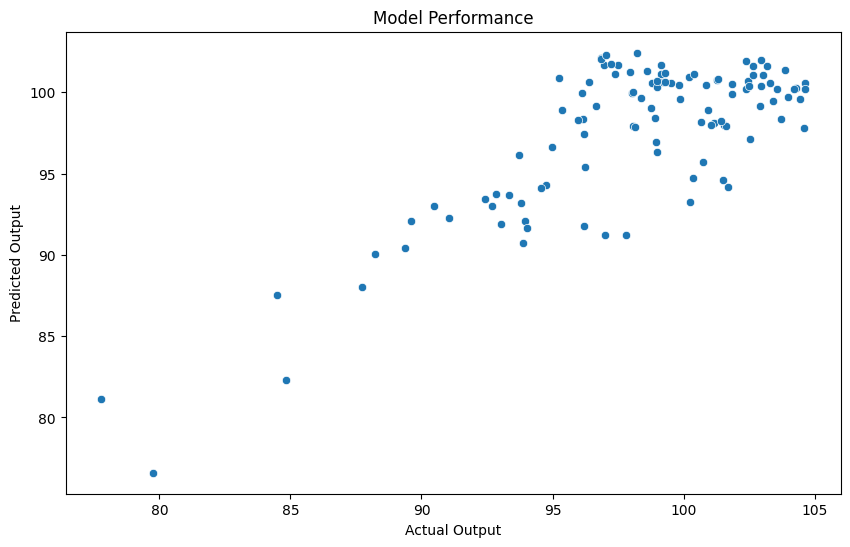

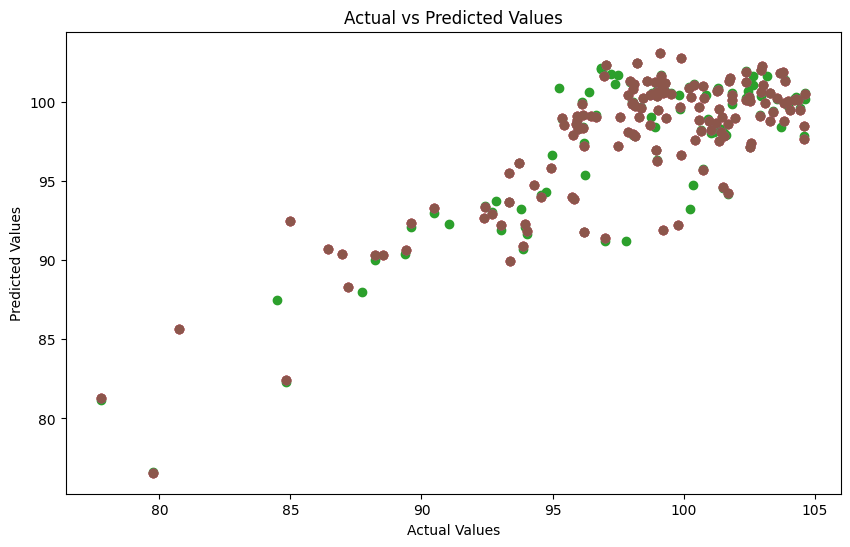

In [ ]:
user_input_list_NREL = ["""Generate a machine learning model to predict next hour's output (energy). The input data of the model is "/content/drive/MyDrive/data_driven_building_energy_modeling/input_NREL.csv" and the output data is "/content/drive/MyDrive/data_driven_building_energy_modeling/output_NREL.csv" """,
                   """Generate a machine learning model to predict next hour's output (energy). The input data of the model is "/content/drive/MyDrive/data_driven_building_energy_modeling/input_NREL.csv" and the output data is "/content/drive/MyDrive/data_driven_building_energy_modeling/output_NREL.csv" """,
                   """Generate a machine learning model to predict next hour's output (energy). The input data of the model is "/content/drive/MyDrive/data_driven_building_energy_modeling/input_NREL.csv" and the output data is "/content/drive/MyDrive/data_driven_building_energy_modeling/output_NREL.csv" """,
                   """Generate a machine learning model to predict next hour's output (energy). The input data of the model is "/content/drive/MyDrive/data_driven_building_energy_modeling/input_NREL.csv" and the output data is "/content/drive/MyDrive/data_driven_building_energy_modeling/output_NREL.csv" """,
                   """Generate a machine learning model to predict next hour's output (energy). The input data of the model is "/content/drive/MyDrive/data_driven_building_energy_modeling/input_NREL.csv" and the output data is "/content/drive/MyDrive/data_driven_building_energy_modeling/output_NREL.csv" """,
                   """Input = "The input data of the model is "/content/drive/MyDrive/data_driven_building_energy_modeling/input_NREL.csv" and the output data is "/content/drive/MyDrive/data_driven_building_energy_modeling/output_NREL.csv",  I want to build a machine learning model based on them.""",
                   """Input = "The input data of the model is "/content/drive/MyDrive/data_driven_building_energy_modeling/input_NREL.csv" and the output data is "/content/drive/MyDrive/data_driven_building_energy_modeling/output_NREL.csv",  I want to build a machine learning model based on them.""",
                   """Input = "The input data of the model is "/content/drive/MyDrive/data_driven_building_energy_modeling/input_NREL.csv" and the output data is "/content/drive/MyDrive/data_driven_building_energy_modeling/output_NREL.csv",  I want to build a machine learning model based on them.""",
                   """Input = "The input data of the model is "/content/drive/MyDrive/data_driven_building_energy_modeling/input_NREL.csv" and the output data is "/content/drive/MyDrive/data_driven_building_energy_modeling/output_NREL.csv",  I want to build a machine learning model based on them.""",
                   """Input = "The input data of the model is "/content/drive/MyDrive/data_driven_building_energy_modeling/input_NREL.csv" and the output data is "/content/drive/MyDrive/data_driven_building_energy_modeling/output_NREL.csv",  I want to build a machine learning model based on them.""",
                   ]

for user_input in user_input_list_NREL:
  print(f"##################### Processing: {user_input} #########################")
  run_agent(user_input)